<a href="https://colab.research.google.com/github/etemadism/Courses/blob/main/ArrayExpress_RNA_seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Google Colab Tutorial: RNA-seq Analysis with edgeR, limma, and pheatmap**

Ali Etemadi


### Introduction

In this session of *Computation and Systems Biology*, we will explore the differential gene expression analysis of RNA-seq data using various computational tools. Our focus is on understanding the **transcriptional landscape of young and senescent human umbilical vein endothelial cells (HUVECs) under normal and high glucose conditions**. By leveraging high-throughput RNA-sequencing (RNA-seq) data, we aim to analyze how cellular senescence and high glucose (HG) levels influence gene expression patterns, which are crucial for understanding endothelial dysfunction in diseases like Type 2 Diabetes (T2D) and cardiovascular disorders.

### About the Dataset

The dataset we will be using consists of RNA-seq data from HUVECs cultured under different conditions:



- Young HUVECs under normal glucose conditions (Group 1)
- Young HUVECs under high glucose conditions (Group 2)
- Senescent HUVECs under normal glucose conditions (Group 3)
- Senescent HUVECs under high glucose conditions (Group 4)

We aim to perform differential expression analysis with the following comparisons:


- Group 1 (Young Normal Glucose) vs. Group 3 (Senescent Normal Glucose)
- Group 2 (Young High Glucose) vs. Group 4 (Senescent High Glucose)


 The goal is to identify differentially expressed genes (DEGs) between these conditions using statistical tools from the R environment, including `limma` and `edgeR`.

### How to Access the Data

The dataset is publicly available under the accession number **[E-MTAB-13959](https://www.ebi.ac.uk/biostudies/arrayexpress/studies/E-MTAB-13959?query=%22type%202%20diabetes%20mellitus%22%20)**. It includes the following files:
- **gene_count_matrix.txt**: Contains the processed gene count data for all 12 samples. Download this and upload it in Files.
- **E-MTAB-13959.idf.txt**: Provides metadata and experimental design information.
- **E-MTAB-13959.sdrf.txt**: Describes the relationship between the samples and data.

The file gene_count_matrix.txt contains RNA-seq gene expression data, specifically representing either raw counts or processed counts (e.g., TPM, RPKM/FPKM, or other normalized measures). TPS is Transcripts Per Million.

You can download the files from the repository and load them into your computational environment for analysis. We will perform normalization, differential expression analysis, and visualize the results using tools such as edgeR, limma, and pheatmap.

Through this hands-on tutorial, you will gain practical experience in analyzing RNA-seq data and interpreting biologically relevant results.



**Important Note**

Before starting the analysis, make sure to change the runtime type to **R** in your Google Colab environment. You can do this by clicking on **Runtime** in the menu, selecting **Change runtime type**, and then choosing **R** from the dropdown menu.


##**Step 1: Set up the environment**

Before starting, you need to install the necessary packages. Google Colab runs in a clean environment, so each session requires package installation.

**BiocManager**: This package manager is essential for installing edgeR and other Bioconductor packages, commonly used for bioinformatics and genomic data analysis.

In [1]:
# RNA-seq Analysis: Comparing Groups
# Comparisons:
# 1. Group 1 (First 3 columns) vs Group 3 (Third 3 columns)
# 2. Group 2 (Second 3 columns) vs Group 4 (Fourth 3 columns)

# Step 1: Install Required Libraries
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install(c("edgeR", "limma", "pheatmap"))



'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.20 (BiocManager 1.30.25), R 4.4.2 (2024-10-31)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'edgeR' 'limma' 'pheatmap'”
Old packages: 'later', 'promises', 'usethis'



##**Step 2: Load the Required Libraries**

Once installed, load the libraries into the environment to access their functions.

**edgeR**: Used for handling RNA-seq data and performing differential expression analysis.

**pheatmap**: Useful for creating heatmaps of gene expression data.

In [2]:
# Step 2: Load Required Libraries
library(edgeR)
library(limma)
library(pheatmap)



Loading required package: limma



##**Step 3: Load and Prepare the Data**

The input data consists of a count matrix (a file with gene expression counts) and sample information that distinguishes control from treatment groups.

In [3]:
# Step 3: Load the Count Matrix
counts <- read.delim("gene_count_matrix.txt", row.names = 1)

# Step 4: Define Sample Information and Experimental Design
# Define groups for each column
sample_info <- data.frame(
  sample = colnames(counts),
  group = factor(c("Group1", "Group1", "Group1",
                   "Group2", "Group2", "Group2",
                   "Group3", "Group3", "Group3",
                   "Group4", "Group4", "Group4"))
)

# Verify sample_info
print(sample_info)

# Create Design Matrix for the Groups
design <- model.matrix(~0 + group, data=sample_info)  # ~0 excludes intercept
colnames(design) <- levels(sample_info$group)

             sample  group
1       s1_NG_1Y_P6 Group1
2       s2_NG_2Y_P6 Group1
3       s3_NG_3Y_P4 Group1
4       s4_HG_1Y_P6 Group2
5       s5_HG_2Y_P6 Group2
6       s6_HG_3Y_P4 Group2
7   s7_NG1_1SEN_P16 Group3
8   s8_NG3_2SEN_P16 Group3
9   s9_NG2_3SEN_P18 Group3
10 s10_HG1_1SEN_P16 Group4
11 s11_HG3_2SEN_P16 Group4
12 s12_HG2_3SEN_P18 Group4


*counts*: A matrix where rows represent genes and columns represent samples. Each entry is the expression count for a gene in a sample.

*sample_info*: Metadata that defines the experimental groups (control and treatment). The condition column specifies the group of each sample.

##**Step 4: Normalize the Data**

Normalization adjusts for variations in library size (total read counts per sample), ensuring fair comparisons between genes and samples.

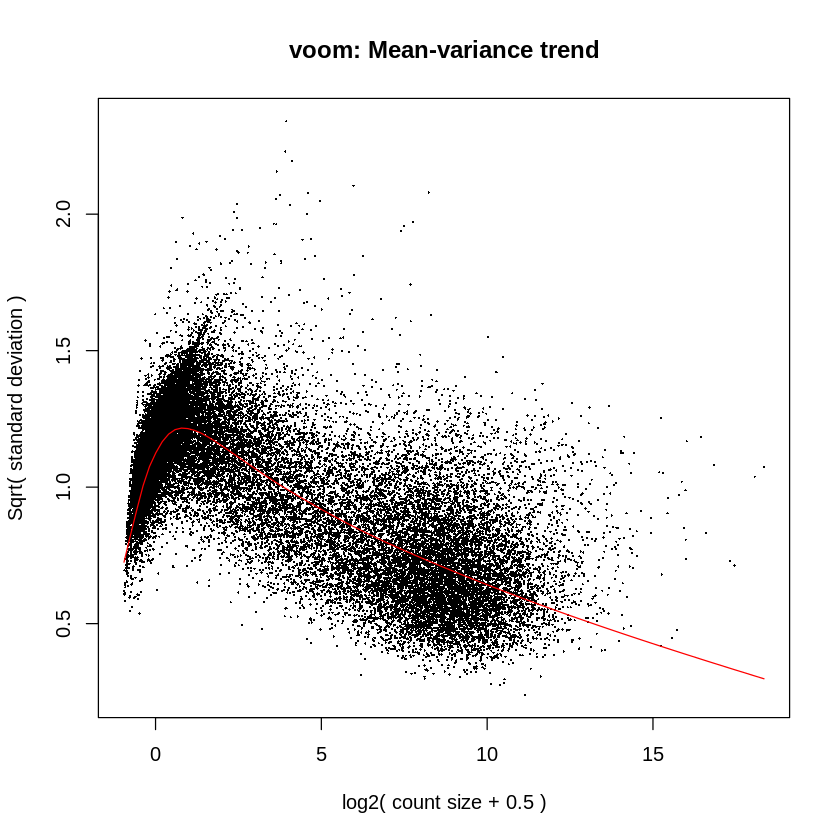

In [4]:
# Step 5: Create DGEList and Normalize Data
dge <- DGEList(counts=counts)
#dge <- calcNormFactors(dge)  # Normalize library sizes ### run it if your data are not normalized.
###in this case data are already dnormalized.

# Step 6: Perform Voom Transformation
v <- voom(dge, design, plot=TRUE)

# Step 7: Fit the Linear Model
fit <- lmFit(v, design)

In [5]:
# Step 8: Define Contrasts for Comparisons
contrast.matrix <- makeContrasts(
  Group1_vs_Group3 = Group1 - Group3,  # Compare Group1 and Group3
  Group2_vs_Group4 = Group2 - Group4,  # Compare Group2 and Group4
  levels = design
)


fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

*calcNormFactors* function scales the counts to account for library size differences between samples.
*voom*: Transforms the count data to log-counts per million (log-CPM) and estimates the mean-variance trend, improving statistical modeling.

*lmFit & eBayes*: Fit the linear model and apply empirical Bayes moderation to shrink variance estimates, leading to more stable results.

##**Step 5: Perform Differential Expression Analysis**

**Get the Top Differentially Expressed Genes**

Now extract the top 10 differentially expressed genes based on their P-values.

In [14]:
# Step 9: Extract Top Genes for Each Contrast
top_Group1_vs_Group3 <- topTable(fit, coef="Group1_vs_Group3", number=10, sort.by="P")
top_Group2_vs_Group4 <- topTable(fit, coef="Group2_vs_Group4", number=10, sort.by="P")
print("These are top 10 DIGs between Group 1 and Group 3")

# Print Top Genes for Each Contrast
print(top_Group1_vs_Group3)

print("===================================================")

print("These are top 10 DIGs between Group 2 and Group 4")
print(top_Group2_vs_Group4)

# Save Results for Each Contrast
write.table(top_Group1_vs_Group3, "DEG_Group1_vs_Group3.txt", sep="\t", quote=FALSE)
write.table(top_Group2_vs_Group4, "DEG_Group2_vs_Group4.txt", sep="\t", quote=FALSE)

[1] "These are top 10 DIGs between Group 1 and Group 3"
                       logFC    AveExpr         t      P.Value    adj.P.Val
ENSG00000165246.15  5.381172 -2.3462037 10.600916 1.009540e-08 0.0006244204
ENSG00000067646.12  4.867483 -2.4582080  9.797001 3.093877e-08 0.0007006408
ENSG00000066248.15 -6.194556 -0.3972773 -9.621641 3.985476e-08 0.0007006408
ENSG00000092969.12 -4.812962  3.6280653 -9.533661 4.531080e-08 0.0007006408
ENSG00000253500.6  -4.735151 -1.6919763 -8.467313 2.301095e-07 0.0024472604
ENSG00000176728.10  4.892754 -2.4530434  8.447677 2.373983e-07 0.0024472604
ENSG00000110848.8  -4.641218 -2.0728622 -8.345566 2.794076e-07 0.0024688459
ENSG00000170961.7  -4.660226 -2.2782952 -8.179801 3.650104e-07 0.0028220777
ENSG00000157601.15 -3.616606  4.3301950 -8.063333 4.413170e-07 0.0028906784
ENSG00000126890.14  5.237655 -2.0687070  7.974400 5.107488e-07 0.0028906784
                          B
ENSG00000165246.15 7.517894
ENSG00000067646.12 6.618023
ENSG00000066248.15 6.045

**topTable**: Retrieves the genes with the most significant differential expression, including log-fold changes and adjusted P-values.


**Volcano Plot and Heatmap for DIGs between group 1 and 3**

A volcano plot shows log-fold changes on the x-axis and the significance (−log10 of P-values) on the y-axis, highlighting the most significantly differentially expressed genes.



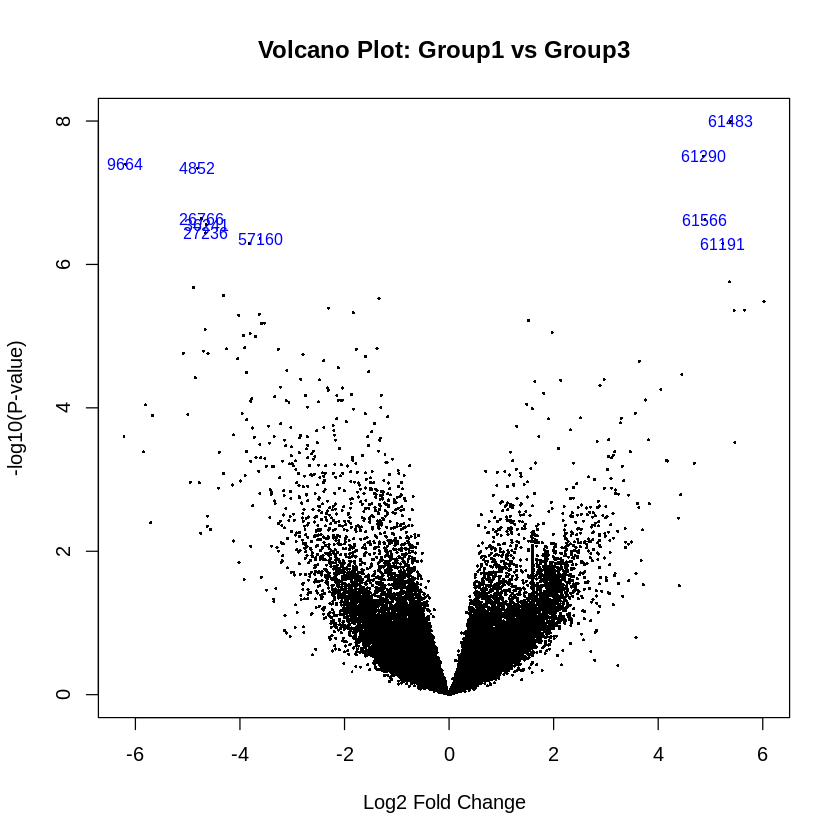

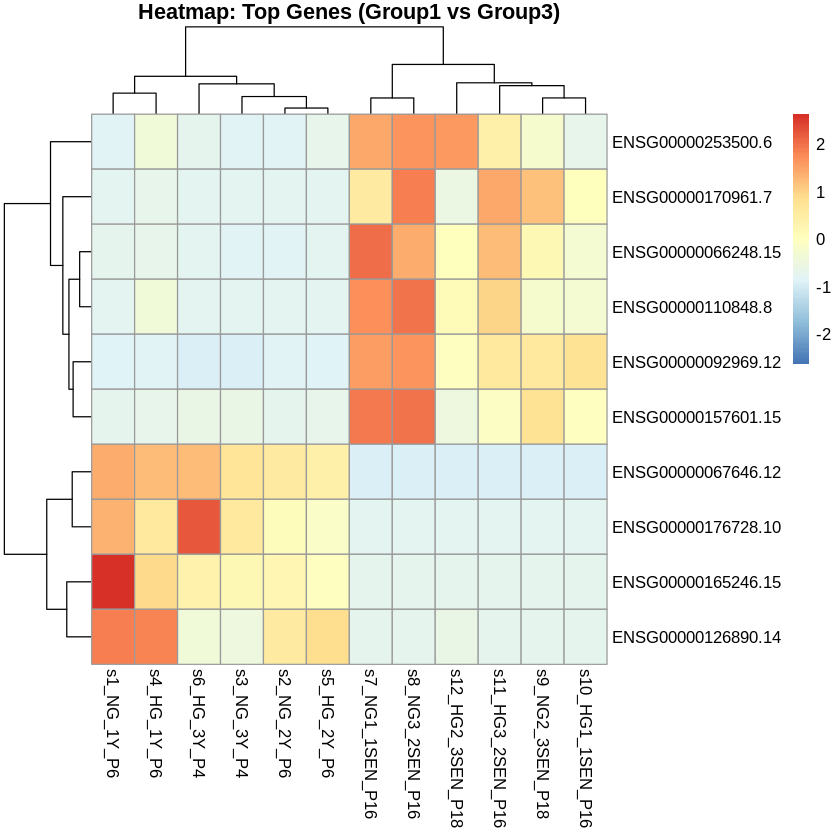

In [7]:
# Step 10: Create Visualizations
# Volcano Plot for "Group1 vs Group3"
volcanoplot(fit, coef="Group1_vs_Group3", highlight=10,
            main="Volcano Plot: Group1 vs Group3")

# Heatmap for Top 10 Genes in "Group1 vs Group3"
top_genes_Group1_vs_Group3 <- rownames(top_Group1_vs_Group3)
top_counts_Group1_vs_Group3 <- counts[top_genes_Group1_vs_Group3, ]

pheatmap(top_counts_Group1_vs_Group3, scale="row", clustering_distance_rows="euclidean",
         clustering_distance_cols="euclidean",
         main="Heatmap: Top Genes (Group1 vs Group3)")

**pheatmap**: Automatically clusters genes and samples by their expression patterns, and the scale="row" argument standardizes each gene's expression.

**Volcano Plot and Heatmap for DIGs between group 2 and 4**


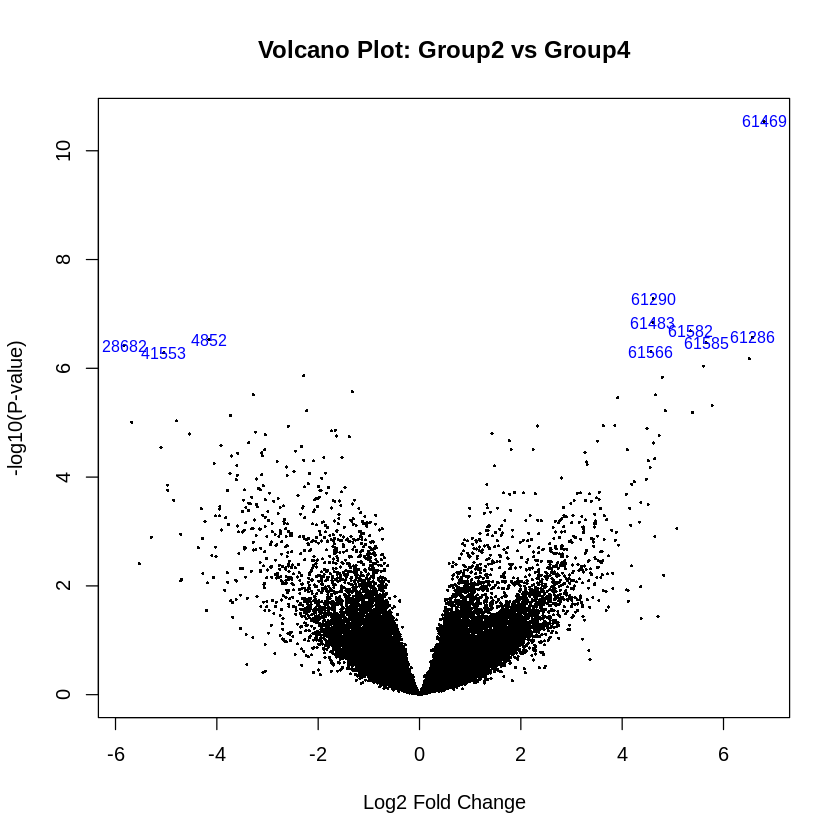

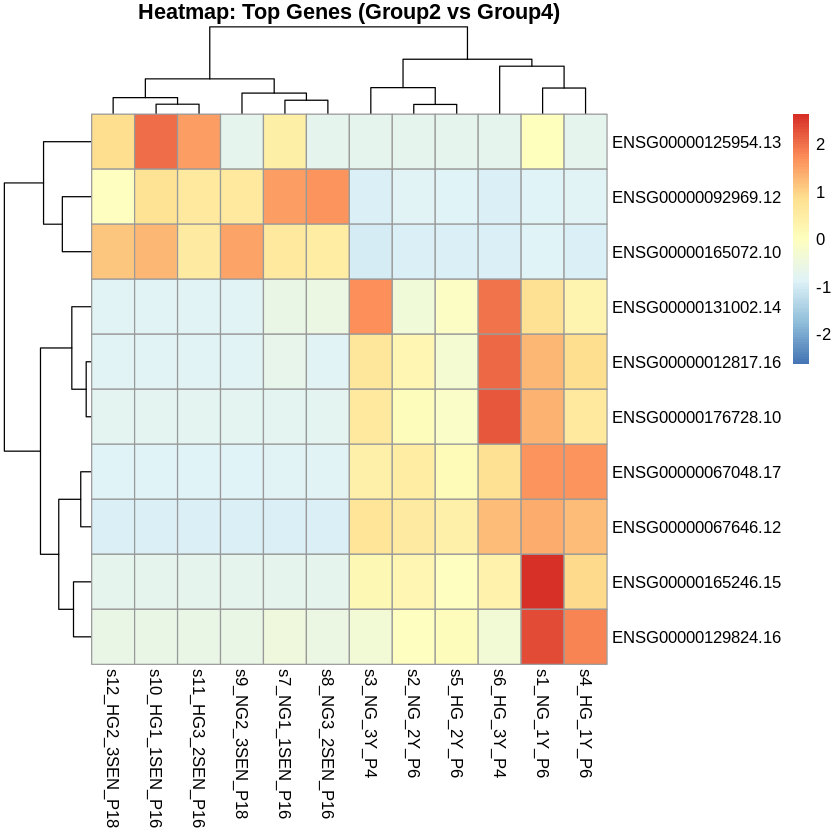

In [8]:

# Volcano Plot for "Group2 vs Group4"
volcanoplot(fit, coef="Group2_vs_Group4", highlight=10,
            main="Volcano Plot: Group2 vs Group4")

# Heatmap for Top 10 Genes in "Group2 vs Group4"
top_genes_Group2_vs_Group4 <- rownames(top_Group2_vs_Group4)
top_counts_Group2_vs_Group4 <- counts[top_genes_Group2_vs_Group4, ]

pheatmap(top_counts_Group2_vs_Group4, scale="row", clustering_distance_rows="euclidean",
         clustering_distance_cols="euclidean",
         main="Heatmap: Top Genes (Group2 vs Group4)")

##**Step 6: Save the Results**

Finally, save the differential expression results for further analysis.

png 
  3

png 
  3

Analysis Complete. Results saved for both comparisons.

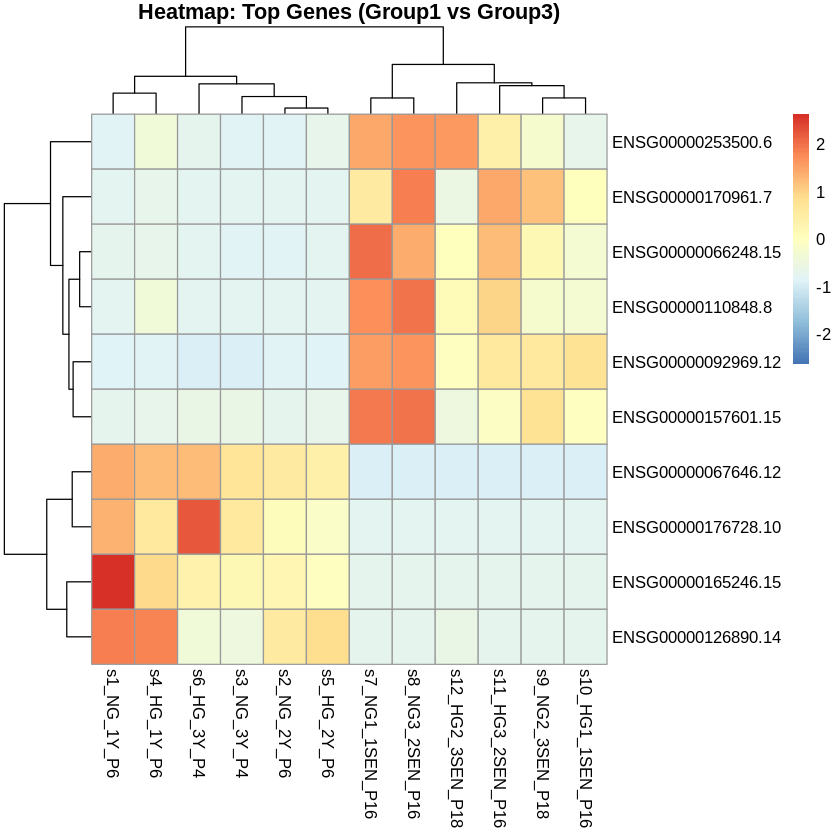

In [9]:
# Save Heatmaps as PNGs
png("heatmap_Group1_vs_Group3.png", width=1200, height=800)
pheatmap(top_counts_Group1_vs_Group3, scale="row", clustering_distance_rows="euclidean",
         clustering_distance_cols="euclidean",
         main="Heatmap: Top Genes (Group1 vs Group3)")
dev.off()

png("heatmap_Group2_vs_Group4.png", width=1200, height=800)
pheatmap(top_counts_Group2_vs_Group4, scale="row", clustering_distance_rows="euclidean",
         clustering_distance_cols="euclidean",
         main="Heatmap: Top Genes (Group2 vs Group4)")
dev.off()

# Step 11: Wrap Up
cat("Analysis Complete. Results saved for both comparisons.")
